In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import Xception 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import os


#### data splitting 

In [5]:
import os
import shutil
import random
import math

# Paths
dataset_path = "DATASET_PLTS"
output_path = "DATASET_SPLIT"

# Split ratios
train_ratio = 0.8
val_ratio = 0.2

# Create output folders
for split in ["train", "val"]:
    os.makedirs(os.path.join(output_path, split), exist_ok=True)

# Function to split and copy images
def split_copy(src_folder, train_dest, val_dest):
    images = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
    random.shuffle(images)
    n_total = len(images)
    
    # Ensure at least one image in each split if possible
    n_train = max(1, math.floor(n_total * train_ratio))
    n_val = max(1, n_total - n_train)
    
    train_images = images[:n_train]
    val_images = images[n_train:]
    
    # Copy images
    for img in train_images:
        shutil.copy(os.path.join(src_folder, img), os.path.join(train_dest, img))
    for img in val_images:
        shutil.copy(os.path.join(src_folder, img), os.path.join(val_dest, img))

# Iterate over fruits
for fruit in os.listdir(dataset_path):
    fruit_path = os.path.join(dataset_path, fruit)
    if not os.path.isdir(fruit_path):
        continue
    
    # Iterate over disease/healthy subfolders
    for subfolder in os.listdir(fruit_path):
        sub_path = os.path.join(fruit_path, subfolder)
        if not os.path.isdir(sub_path):
            continue
        
        # Create destination folders for train/val
        train_dest = os.path.join(output_path, "train", fruit, subfolder)
        val_dest = os.path.join(output_path, "val", fruit, subfolder)
        os.makedirs(train_dest, exist_ok=True)
        os.makedirs(val_dest, exist_ok=True)
        
        # Split and copy
        split_copy(sub_path, train_dest, val_dest)

print("Data splitting complete! Train/Validation splits created with hierarchy preserved.")


KeyboardInterrupt: 

#### Modelling 

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

#### directories

In [20]:
train_dir = "DATASET_SPLIT/train"
val_dir = "DATASET_SPLIT/val"


#### data generator

In [21]:
IMAGE_SIZE = (128,128)
BATCH = 32

train_gen = ImageDataGenerator(
   
    rescale=1./255, # Rescale to 0-1 range
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
).flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode='categorical'
)

val_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode='categorical'
)


Found 46814 images belonging to 16 classes.
Found 11790 images belonging to 16 classes.


#### Transfer learning model

In [22]:
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False   # Freeze layers (super fast training)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


#### model training

In [23]:
import time
from tensorflow.keras.callbacks import Callback

class TimeLimit(Callback):
    def __init__(self, max_seconds=9000):  # default = 5 minutes
        super(TimeLimit, self).__init__()
        self.max_seconds = max_seconds

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_batch_end(self, batch, logs=None):
        if time.time() - self.start_time > self.max_seconds:
            print("\n⛔ Time limit reached. Stopping training...")
            self.model.stop_training = True

In [ ]:

time_callback = TimeLimit(max_seconds=9000) 
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5, callbacks=[time_callback]
)


Epoch 1/5
  64/1463 ━━━━━━━━━━━━━━━━━━━━ 39:51 2s/step - accuracy: 0.4761 - loss: 1.8459

#### saving the model

In [ ]:
model.save("mobileNet_model2.h5")


#### Model evaluation

#### 1.Acuracy score

In [ ]:
#accuracy score and loss 
# Evaluate model on validation set
loss, acc = model.evaluate(val_gen)
print("Validation Accuracy:", acc)
print("Validation Loss:", loss)


 22/369 ━━━━━━━━━━━━━━━━━━━━ 8:25 1s/step - accuracy: 0.9194 - loss: 0.2917

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000020B37D44590>
Traceback (most recent call last):

  File "c:\Users\user\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)

  File "c:\Users\user\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\user\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 264, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py", line 71, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^

  File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py", line 316, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
        filepaths[j],
    ...<3 lines>...
        keep_aspect_ratio=self.keep_aspect_ratio,
    )

  File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\utils\image_utils.py", line 236, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "c:\Users\user\anaconda3\Lib\site-packages\PIL\Image.py", line 3532, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000020B37D44590>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_13845]

#### 2. generate prediction

In [ ]:

# Get true labels
true_labels = val_gen.classes

# Predict probabilities
pred = model.predict(val_gen)
pred_labels = np.argmax(pred, axis=1)

class_names = list(val_gen.class_indices.keys())



366/366 ━━━━━━━━━━━━━━━━━━━━ 3114s 8s/step


#### 3. Clasiffication report

In [ ]:
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))



Classification Report:


c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

                   APPLE       0.07      0.07      0.07       929
               BLUEBERRY       0.03      0.03      0.03       301
                 CABBAGE       0.00      0.00      0.00        38
                  CHERRY       0.03      0.02      0.02       411
                    CORN       0.06      0.06      0.06       872
                  GRAPES       0.07      0.08      0.08       929
                  ONIONS       0.00      0.00      0.00        31
                 ORANGES       0.10      0.12      0.11      1133
                   PEACH       0.06      0.05      0.06       690
                  PEPPER       0.03      0.03      0.03       496
                  POTATO       0.04      0.04      0.04       600
                 SOYBEAN       0.08      0.08      0.08      1018
              STRAWBERRY       0.05      0.04      0.04       422
                 TOBACCO       0.00      0.00      0.00        31
         

#### 4. Confusion matrix 

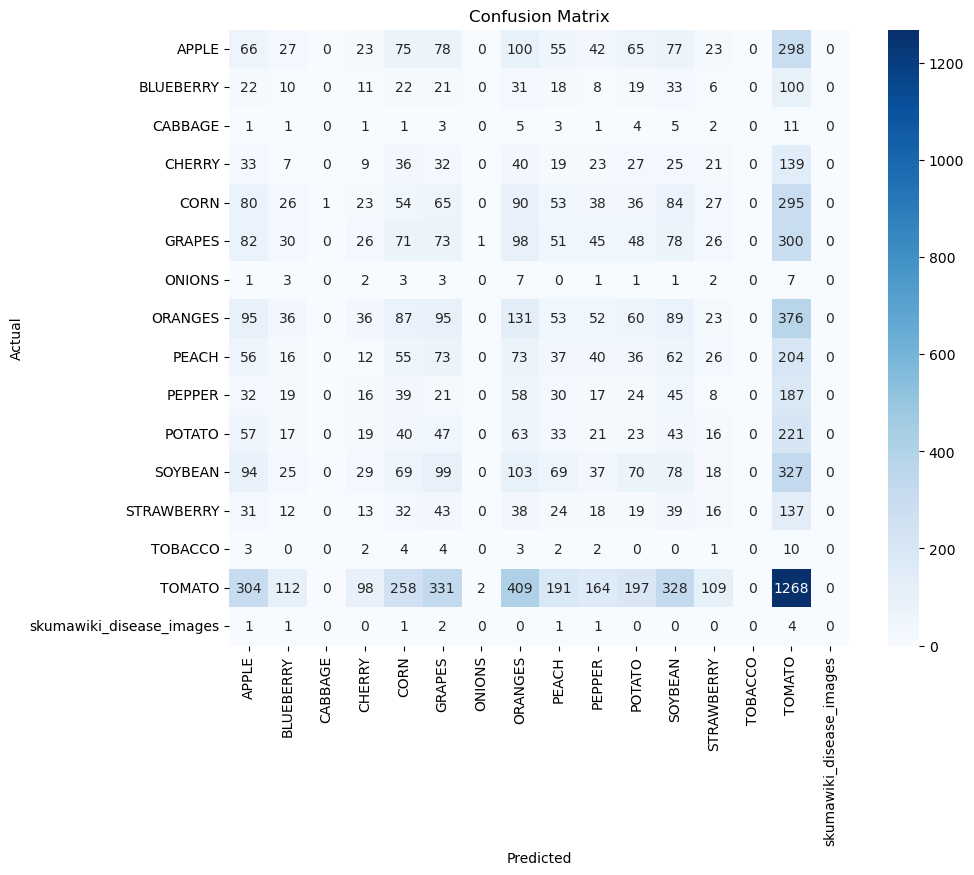

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#### 5.Plot accuracy and loss curve

In [ ]:
# Accuracy plot
plt.figure(figsize=(10,5))
# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

#### InceptionV3

In [ ]:
train_dir = "DATASET_SPLIT/train"
val_dir = "DATASET_SPLIT/val"


#### Data Generator

In [ ]:
IMAGE_SIZE = (128, 128)
BATCH = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
).flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode='categorical'
)

val_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode='categorical'
)


Found 46649 images belonging to 16 classes.
Found 11683 images belonging to 16 classes.


##### transfer learning

In [ ]:
base_model = InceptionV3(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False   # Freeze layers (super fast training)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


#### model training 

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_generator,
    epochs=3
)

Epoch 1/3
  16/1458 ━━━━━━━━━━━━━━━━━━━━ 7:29:06 19s/step - accuracy: 0.2724 - loss: 3.1910

KeyboardInterrupt: 

#### saving the model

In [ ]:
model.save("inceptionv3_model2.h5")


#### Model evaluation

#### 1. Accuracy score

In [ ]:
#accuracy score and loss 
# Evaluate model on validation set
loss, acc = model.evaluate(val_generator)
print("Validation Accuracy:", acc)
print("Validation Loss:", loss)


366/366 ━━━━━━━━━━━━━━━━━━━━ 2248s 6s/step - accuracy: 0.8721 - loss: 0.4180
Validation Accuracy: 0.8721218705177307
Validation Loss: 0.41796591877937317


#### 2. Generate prediction

In [ ]:

# Get true labels
true_labels = val_gen.classes

# Predict probabilities
pred = model.predict(val_generator)
pred_labels = np.argmax(pred, axis=1)

class_names = list(val_generator.class_indices.keys())


#### 3. Classification Report

In [ ]:
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))



#### 4. Confusion matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#### 5. plot accuracy and loss curve

In [ ]:
# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()
